In [3]:
import scarlink.src.visualization as scv
import matplotlib.pyplot as plt
import pandas
import numpy as np
import os

In [4]:
# make tmp directory
os.makedirs("./tmp/", exist_ok=True)
os.makedirs("./scarlink_outs/", exist_ok=True)

### Download data files and SCARlink models from figshare

In [5]:
# PBMC
!( \
if [ ! -d ./scarlink_outs/pbmc_all_out_10k ]; then \
cd ./scarlink_outs; \
wget https://figshare.com/ndownloader/files/44297825?private_link=9b9e89ff3150aebb6d7a -O ./pbmc_all_out_10k.zip; \
unzip pbmc_all_out_10k.zip; rm pbmc_all_out_10k.zip; \
fi)

In [6]:
def plot_output(scarlink_out_dir, gene, ukbb_file, trait):
    scarlink_out = scv.get_scarlink_output(scarlink_out_dir)
    scv.plot_scarlink_output(scarlink_out, genes=[gene], celltype='celltype', figsize=(15, 39), 
                        show_yticks=True)
    ax = plt.gca()
    ax_list = plt.gcf().axes

    fdr_cutoff = 1e-3
    z_score_cutoff = 0.5
    pip_cutoff = 0.2
    
    ax = list(filter(lambda x: x.get_ylabel() == 'Coefficients', ax_list))[0]
    df = pandas.read_csv(ukbb_file, sep='\t')
    df_g = df[(df['gene'] == gene) & (df['pip'] > pip_cutoff) & (df['trait'].isin(trait))]
    for i,r in df_g[['Chromosome', 'Start', 'End']].drop_duplicates().iterrows():
        y1, y2 = ax.get_ylim()
        ax.set_ylim(y1, y2)
        ypos = (y1 + y2)/2
        ax.plot(r['Start'], -ypos, markersize=5, clip_on=False, marker='o', # "^", #'.', 
                        color='grey')
    df_g = df_g[(df_g['adj_pval'] < fdr_cutoff) & (df_g['z-score'] > z_score_cutoff)]
    if df_g.empty: return

    scarlink_tiles = pandas.read_csv(scarlink_out_dir + 'gene_linked_tiles_celltype.csv.gz',
                                     sep='\t', engine='pyarrow')
    scarlink_tiles = scarlink_tiles[(scarlink_tiles['gene']==gene) & (scarlink_tiles['FDR'] < fdr_cutoff) & 
                                    (scarlink_tiles['z-score'] > z_score_cutoff) & 
                                    (scarlink_tiles['start'] <= df_g.iloc[0]['Start']) & 
                                    (scarlink_tiles['end'] >= df_g.iloc[0]['End'])]
    scarlink_tiles['Start'] = df_g.iloc[0]['Start']
    for i,r in scarlink_tiles.iterrows():
        y1, y2 = ax.get_ylim()
        ax.set_ylim(y1, y2)
        ypos = (y1 + y2)/2
        ax.plot(r['Start'], -ypos, markersize=9-5, clip_on=False, marker="^", #'|'
                        color='red')

        if gene == 'CCR7':
            # add coloc eQTL -- from Supplementary Table 8
            ax.plot(40600717, -ypos, markersize=9-5, clip_on=False, marker="^", #'|', 
                                    color='blue')
            # add closest significant tile -- from Supplementary Table 8 
            ax.plot(40602000, -ypos-0.001, markersize=6, clip_on=False, marker='|',
                                    color='black')
            ax.plot(40601500, -ypos-0.001, markersize=6, clip_on=False, marker='|',
                                    color='black')

        if gene == 'BCL2':
            # add coloc eQTL -- from Supplementary Table 8
            ax.plot(63179197, -ypos, markersize=9-5, clip_on=False, marker="^", #'|', 
                                    color='blue')
            # add closest significant tile -- from Supplementary Table 8
            ax.plot(63179000, -ypos-0.001, markersize=6, clip_on=False, marker='|',
                                    color='black')
            ax.plot(63179500, -ypos-0.001, markersize=6, clip_on=False, marker='|',
                                    color='black')
            
        ax_celltype = list(filter(lambda x: x.get_ylabel() == r['celltype'], ax_list))[0]
        ylm = ax_celltype.get_ylim()
        yrange = ylm[1] - ylm[0]
        ypos = ylm[0] - 0.1*yrange
        ax_celltype.plot(r['Start'], ypos, markersize=8, clip_on=False, marker='o', 
                                 markerfacecolor="None", markeredgecolor='red')

In [7]:
pbmc_scarlink_out = "./scarlink_outs/pbmc_all_out_10k/"

In [8]:
# generated in figure_3.ipynb
pbmc_ukbb_file = "./tmp/pbmc_ukbb.csv.gz"

Saved as ./scarlink_outs/pbmc_all_out_10k/scarlink_plots/BCL2.png


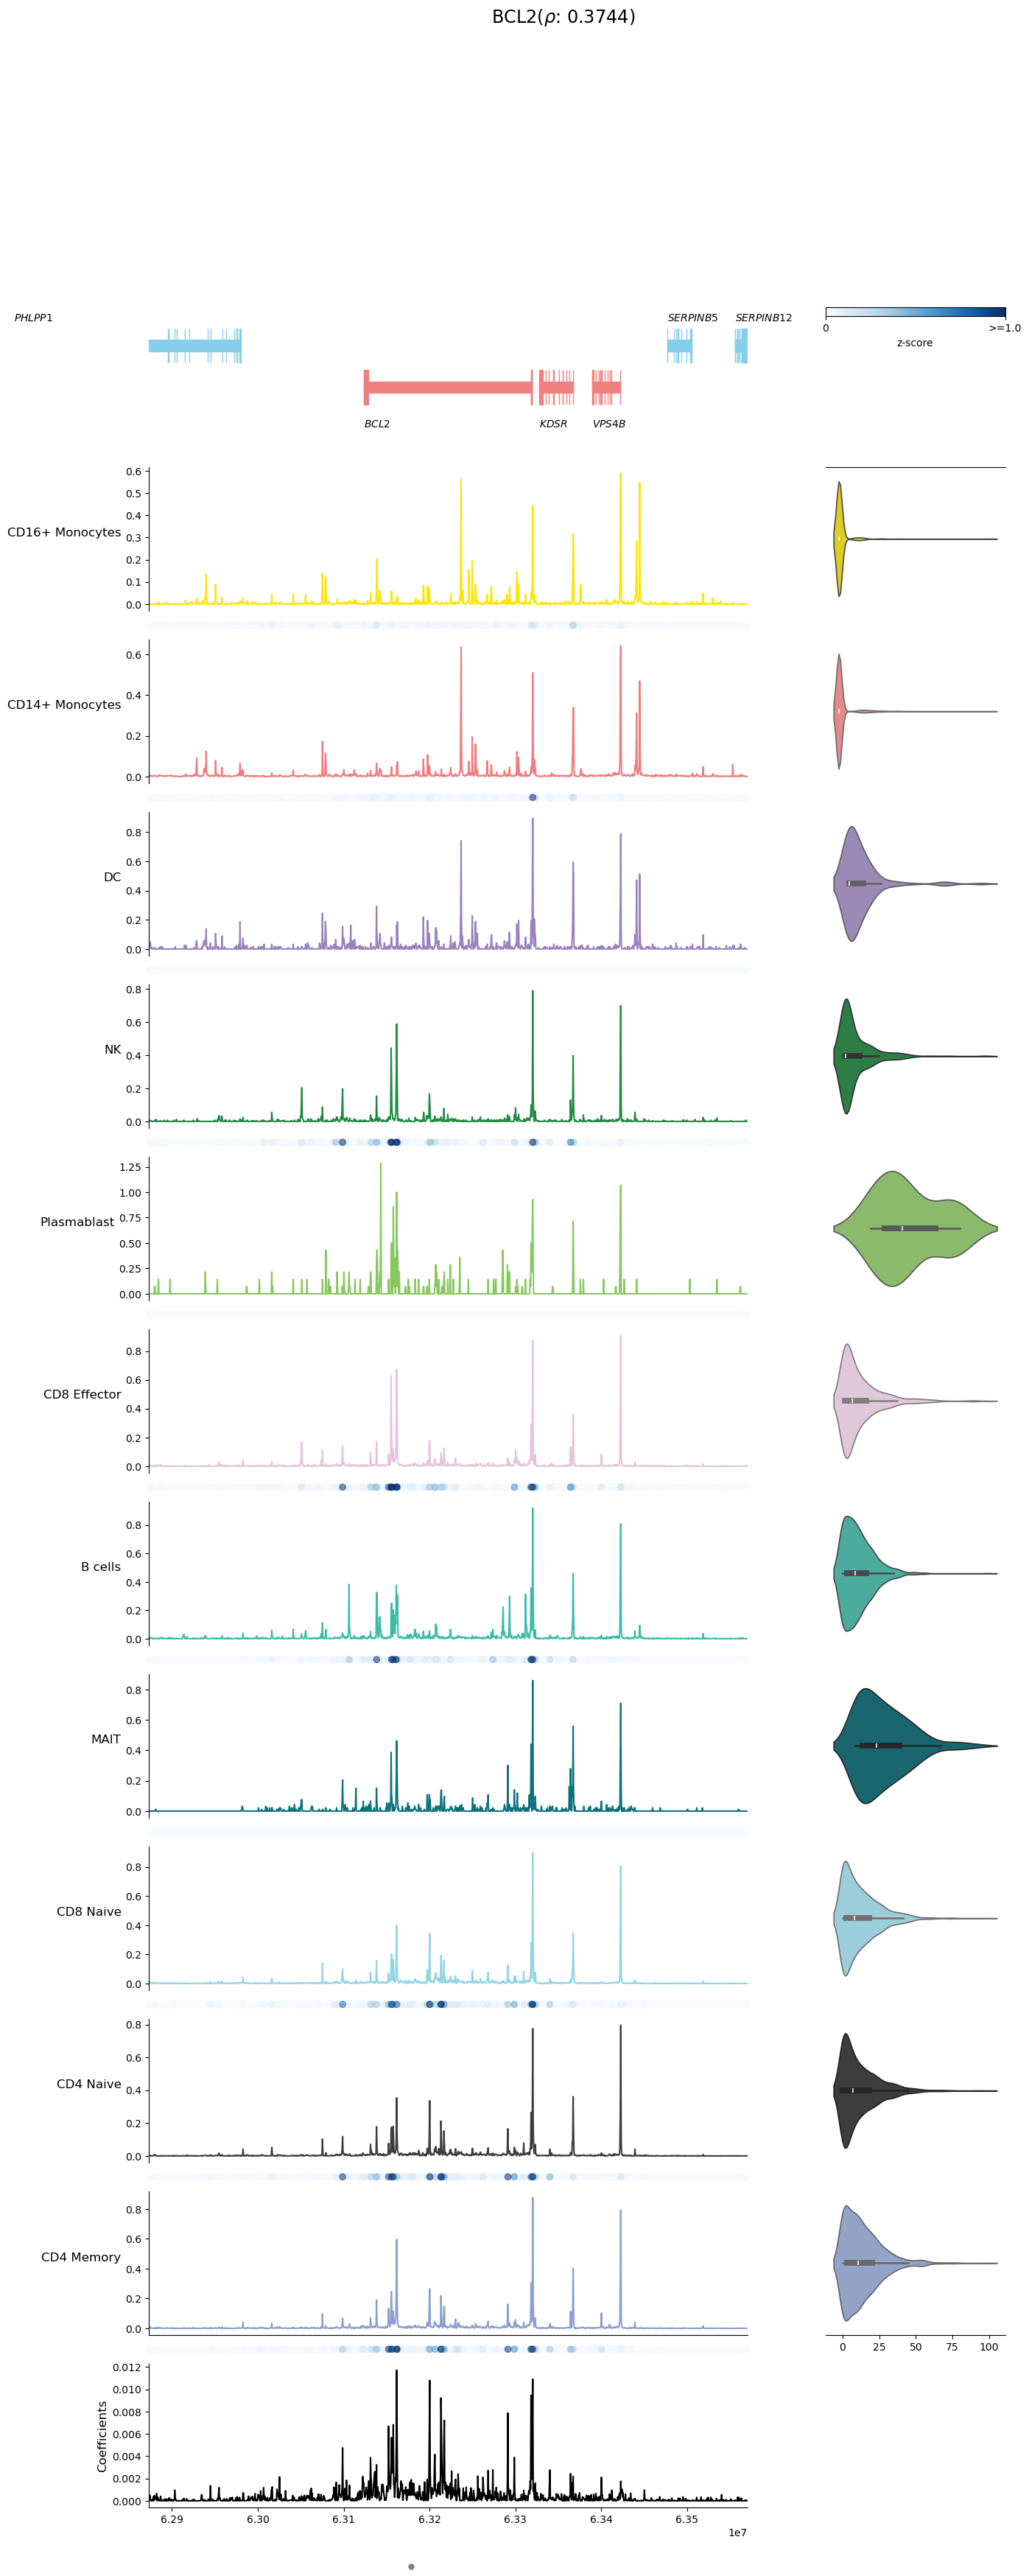

In [9]:
plot_output(pbmc_scarlink_out, 'BCL2', pbmc_ukbb_file, ['T2D_BMI', 'IGF1'])